<a href="https://colab.research.google.com/github/nulllpointer/Thesis/blob/master/Rice_Leaf_Disease_Classification_augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")




In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')
path= '/content/drive/My Drive/rice'
path = Path(path)
data_path = path/'original dataset'
data_path


Mounted at /content/drive


PosixPath('/content/drive/My Drive/rice/original dataset')

# **Load Dataset**

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]


['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


LabelLists;

Train: LabelList (96 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Brown spot,Brown spot,Brown spot,Brown spot,Brown spot
Path: /content/drive/My Drive/rice/original dataset;

Valid: LabelList (24 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Leaf smut,Bacterial leaf blight,Leaf smut,Brown spot,Brown spot
Path: /content/drive/My Drive/rice/original dataset;

Test: None

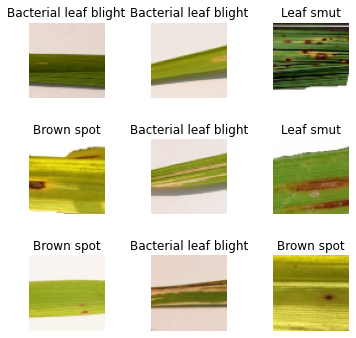

In [ ]:
# **Load Dataset**
bs = 64
tfms = get_transforms(do_flip=False, flip_vert=True)
data = ImageDataBunch.from_folder(data_path, ds_tfms=tfms, size=bs, valid_pct=0.2)
data.show_batch(rows=3, figsize=(5,5))
print(data.classes)
len(data.classes),data.c
data.label_list

# DenseNet Models

In [ ]:
densenet_pretrained = cnn_learner(data, models.densenet201, pretrained=True, metrics=[error_rate, accuracy])
densenet_pretrained.fit_one_cycle(5)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.070628,1.260664,0.541667,0.458333,00:22
1,2.047615,1.238340,0.625000,0.375000,00:07
2,1.779976,1.322023,0.583333,0.416667,00:07
3,1.523266,1.461720,0.625000,0.375000,00:07
4,1.306185,1.587360,0.666667,0.333333,00:07


In [ ]:
 densenet_pretrained.recorder.plot_losses()
densenet_pretrained.save('densenet-15-epcohs')

In [ ]:
densenet = cnn_learner(data, models.densenet201, pretrained=False, metrics=accuracy)
densenet.fit_one_cycle(5)

# Resnet50

In [ ]:
resnet50 = cnn_learner(data, models.resnet50, pretrained=True, metrics=accuracy)
resnet50.fit_one_cycle(5)

In [ ]:
resnet50 = cnn_learner(data, models.resnet50, pretrained=False, metrics=accuracy)
resnet50.fit_one_cycle(5)

# squeezenet1_1 Model

In [ ]:
squeezenet1_1 = cnn_learner(data, models.squeezenet1_1, pretrained=True,  metrics=accuracy)
squeezenet1_1.fit_one_cycle(5)

In [ ]:
squeezenet1_1 = cnn_learner(data, models.squeezenet1_1, pretrained=False, metrics=accuracy)
squeezenet1_1.fit_one_cycle(5)

# Pretained VGG Model

In [ ]:
learn = cnn_learner(data, models.vgg19_bn, pretrained=True, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(5)

# **Model Interpretation**

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.most_confused(min_val=2)



# **Saving Model**

In [ ]:
learn.save('vgg-stage-1')

# Learning **Rate** Fine Tuning

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


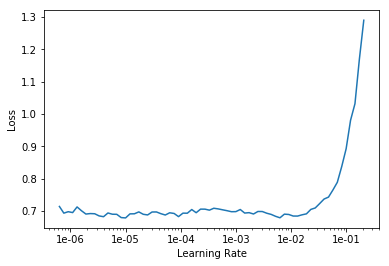

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.682794,0.482429,0.854460,06:09
1,0.616524,0.417584,0.882629,06:12
2,0.566868,0.493039,0.861502,06:10
3,0.580501,0.568185,0.845070,06:08
4,0.564343,0.374543,0.887324,06:12
5,0.545944,0.411475,0.906103,06:07
6,0.479573,0.379652,0.903756,06:10
7,0.423197,0.420928,0.908451,06:10
8,0.357540,0.300533,0.941315,06:12
9,0.285607,0.314823,0.931925,06:10


In [ ]:
learn.save('vgg-stage-2')
learn.load('vgg-stage-2')
learn.export()


# Fine tuning DenseNet


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


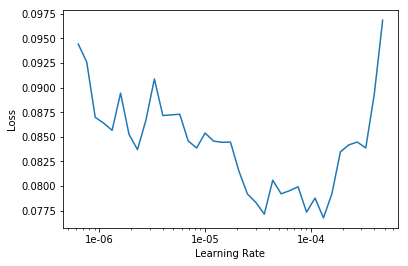

In [ ]:
densenet_pretrained.unfreeze()
densenet_pretrained.lr_find()
densenet_pretrained.recorder.plot()

In [ ]:
densenet_pretrained.load()
densenet_pretrained.fit_one_cycle(10, max_lr=slice(1e-4,1e-4))

In [ ]:
densenet_pretrained.load('densenet-15-epcohs')
densenet_pretrained.fit_one_cycle(10, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.089580,0.169182,0.053991,0.946009,03:36
1,0.077375,0.166032,0.056338,0.943662,03:34
2,0.079249,0.158407,0.046948,0.953052,03:36
3,0.078651,0.161855,0.056338,0.943662,03:40
4,0.083199,0.158539,0.049296,0.950704,03:42
5,0.084540,0.159022,0.053991,0.946009,03:40
6,0.075812,0.154320,0.049296,0.950704,03:44
7,0.067410,0.150150,0.046948,0.953052,03:49
8,0.067307,0.153190,0.049296,0.950704,03:49
9,0.066462,0.157871,0.049296,0.950704,03:48


In [ ]:
densenet_pretrained.recorder.plot_losses()

In [ ]:
path = Path('/content/drive/My Drive/plant_classification')
%cd /content/drive/My Drive/plant_classification
densenet_pretrained.save('densenet-fine-tuned')
densenet_pretrained.load('densenet-fine-tuned')
densenet_pretrained.export('densenet-fine-tuned')

[Errno 2] No such file or directory: '/content/drive/My Drive/plant_classification'
/content
